In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [ ]:
from google.colab import drive
import os
drive.mount('/drive')

# --- your paths here --- # 
nasdaq_path = '/drive/MyDrive/Finance_labs/NASDAQ.xlsx' 
index_ixic_path = '/drive/MyDrive/Finance_labs/index_ixic.csv' 
data_path = '/drive/MyDrive/Finance_labs/data'

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## 1. Data collection 

In [ ]:
nasdaq = pd.read_excel(nasdaq_path)
tickers = nasdaq['Symbol']
tickers_list = list()
for ticker in tickers:
    tickers_list.append(ticker)

In [ ]:
#stock data

if 'data' not in os.listdir('/drive/MyDrive/Finance_labs/'):
  data = yf.download(tickers_list,'2019-01-02','2019-12-31')
  data.to_pickle(data_path)
else:
  data = pd.read_pickle(data_path)

data = data.drop(columns = ['Low', 'High', 'Open', 'Close'])
#market index data
index = pd.read_csv(index_ixic_path, sep=",")
index = index.drop(columns = ['Low', 'High', 'Open', 'Close']) 

[*****************     35%                       ]  1763 of 5013 completed

Exception in thread Thread-1775:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multitasking/__init__.py", line 102, in _run_via_pool
    return callee(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 170, in _download_one_threaded
    actions, period, interval, prepost, proxy, rounding)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 185, in _download_one
    rounding=rounding, many=True)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/base.py", line 159, in history
    raise RuntimeError("*** YAHOO! FINANCE IS CURRENTLY DOWN! ***\n"
RuntimeError: *** YAHOO! FINANCE IS CURRENTLY DOWN! ***
Our engineers are working quickly to resolve the issue. Thank you for your patience.



[**********************88%*****************      ]  4400 of 5013 completed

In [ ]:
adj_close = data['Adj Close'] # adjusted closing price
volume = data['Volume'] # sales volume

adj_close.reset_index(level=0, inplace=True) # set index from date to int
volume.reset_index(level=0, inplace=True)

for i in range(0, len(adj_close['Date'])):
    volume.loc[i, 'Date'] = str(volume['Date'][i].date())
    adj_close.loc[i, 'Date'] = str(adj_close['Date'][i].date())


adj_indexes = set(adj_close['Date'].to_list())
ind_indexes = set(index['Date'].to_list())
diff = adj_indexes.difference(ind_indexes)
diff, adj_close.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


({'2019-11-28'}, (252, 5014))

In [ ]:
adj_close = adj_close.loc[adj_close['Date'] != '2019-11-28']
volume = volume.loc[volume['Date'] != '2019-11-28']
#handling missing values
adj_close = adj_close.dropna(axis=1, how='any')
volume = volume.dropna(axis=1, how='any')
#add the index data to the main data
adj_close['IXIC'] = index['Adj Close']
volume['IXIC'] = index['Volume']
adj_close = adj_close.loc[adj_close['Date'] != '2019-12-30']
volume = volume.loc[volume['Date'] != '2019-12-30']

In [ ]:
#reduce the number of tickers
tickers_to_delete = adj_close.columns.to_list()
tickers_to_delete.remove('Date')
tickers_to_delete.remove('IXIC')
tickers_to_delete = tickers_to_delete[::2]
adj_close.drop(tickers_to_delete, inplace=True, axis=1) 
volume.drop(tickers_to_delete, inplace=True, axis=1) 

In [ ]:
adj_close.shape

(250, 1188)

In [ ]:
adj_close

,Date,AADR,AAOI,AAPL,AAXJ,ABEO,ABMD,ABUS,ACB,ACER,ACGL,ACGLP,ACHV,ACIW,ACMR,ACOR,ACRX,ACTG,ACWX,ADBE,ADI,ADMA,ADMS,ADRE,ADTN,ADVM,AEHR,AEMD,AERI,AEZS,AFMD,AGFS,AGLE,AGNCN,AGTC,AGZD,AIHS,AIMC,AIQ,AIRR,...,WHLR,WING,WISA,WKHS,WLFC,WNEB,WORX,WRAP,WSBC,WSC,WSTG,WTER,WTFCM,WVE,WW,WYNN,XBIT,XELA,XENE,XERS,XLNX,XNCR,XOMA,XPER,XSPA,XXII,YMTX,YORW,YTRA,YY,ZBRA,ZEST,ZG,ZION,ZIOP,ZKIN,ZNGA,ZSAN,ZYNE,IXIC
0,2019-01-02,39.938866,15.88,38.439735,60.990410,7.03,309.959991,4.00,62.880001,21.450001,26.190001,17.710270,25.600000,27.139999,10.870000,97.320000,2.48,3.10,39.171585,224.570007,81.788750,2.62,9.07,35.411957,10.092703,3.41,1.54,23.700001,36.320000,3.03,3.22,3.86,8.04,21.402365,2.65,44.627411,3.880,25.264870,12.847092,21.746164,...,0.832,58.632019,71.400002,0.650,35.669998,9.322553,3.515,3.24,33.768852,9.600000,9.085455,2.950,21.858183,41.009998,39.889999,100.250526,4.437493,11.790,6.68,17.50,84.360565,35.790001,13.270000,17.746609,9.60,2.67,69.400002,30.315119,4.23,60.275311,156.240005,3.775,30.350000,38.495026,2.21,1.570,3.98,2.34,3.72,6665.939941
1,2019-01-03,39.493225,15.06,34.610851,59.549995,6.62,302.290009,3.77,61.680000,20.400000,25.780001,17.719034,26.200001,25.160000,10.370000,95.400002,2.60,3.00,38.806190,215.699997,76.848297,2.81,9.26,34.674816,10.120609,3.38,1.49,22.350000,37.080002,3.08,3.05,3.74,7.93,21.427486,2.62,44.533165,3.700,24.204943,12.511349,21.556807,...,1.120,57.823109,65.800003,0.695,34.950001,9.266449,3.325,3.25,33.561562,9.490000,9.408335,2.680,22.133125,38.930000,36.549999,99.280663,4.351328,11.190,6.39,16.83,81.184296,34.860001,12.730000,17.189417,10.20,2.61,68.000000,29.806831,4.13,58.230923,146.880005,4.000,30.020000,38.282089,2.15,1.471,3.92,2.41,3.67,6463.500000
2,2019-01-04,41.028198,15.54,36.088364,61.512444,7.02,313.440002,4.10,62.639999,21.500000,26.389999,18.279871,27.000000,26.170000,10.700000,100.320000,2.74,2.99,40.005417,226.190002,78.714058,2.95,9.21,35.964817,10.474086,3.56,1.44,22.200001,37.759998,3.41,3.28,3.81,8.42,21.318634,2.72,44.759365,3.790,25.476854,13.014962,22.254438,...,1.060,59.678852,72.599998,0.790,35.419998,9.509562,3.325,3.25,34.579952,9.950000,9.148236,2.888,22.270601,41.169998,37.320000,103.284927,4.532275,11.670,6.87,17.50,84.943359,36.580002,13.280000,18.155218,9.60,2.76,72.599998,30.209621,4.33,61.850182,152.970001,4.500,30.809999,39.457855,2.24,1.670,4.02,2.64,4.00,6738.859863
3,2019-01-07,41.513439,15.68,36.008041,61.879795,7.51,314.799988,4.20,63.119999,23.090000,26.330000,18.674212,27.000000,26.510000,10.750000,99.000000,2.84,3.07,40.061630,229.259995,79.209045,3.14,9.62,36.061810,10.734541,3.54,1.36,22.650000,40.369999,3.49,3.41,4.04,8.37,21.352123,2.94,44.617985,3.810,26.093542,13.261831,22.613216,...,1.065,64.170723,72.000000,0.780,36.759998,9.472162,3.667,3.12,34.643032,10.530000,9.193080,2.750,22.528360,43.369999,35.950001,105.119019,4.575357,12.030,7.53,17.84,87.187141,38.090000,14.650000,18.703125,10.20,2.84,74.199997,29.931499,4.45,63.845669,155.289993,4.300,30.980000,39.615250,2.27,1.700,4.07,2.72,4.00,6823.470215
4,2019-01-08,41.800625,16.01,36.694466,62.044132,7.31,318.420013,4.05,60.360001,23.500000,26.430000,18.937109,26.600000,27.389999,10.730000,97.080002,2.74,3.14,40.323959,232.679993,81.141441,3.41,9.56,36.614658,11.004300,3.51,1.36,22.500000,39.689999,3.35,3.50,4.05,8.43,21.430834,2.96,44.853607,3.870,26.922216,13.390204,22.902237,...,1.130,66.873444,77.800003,0.756,36.990002,9.434759,3.838,3.05,34.850315,10.240000,9.246894,2.720,22.786121,43.779999,36.770000,108.412689,4.670138,11.970,8.28,18.74,85.526176,38.009998,14.510000,19.102449,10.80,2.85,73.400002,30.171261,4.77,63.992390,156.330002,4.000,31.809999,39.976315,2.19,1.550,4.14,2.77,4.12,6897.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## 2. Logarithmic returns, expected value and standard deviation estimations


In [ ]:
# calculate logarithmic returns
log_returns = pd.DataFrame(index = adj_close.index, columns = adj_close.columns)
log_returns['Date'] = adj_close['Date']
tickers = adj_close.columns.to_list()
tickers.remove('Date')
for ticker in tickers:
    log_returns[ticker] = np.log(1 + adj_close[ticker].pct_change())

In [ ]:
log_returns

,Date,AADR,AAOI,AAPL,AAXJ,ABEO,ABMD,ABUS,ACB,ACER,ACGL,ACGLP,ACHV,ACIW,ACMR,ACOR,ACRX,ACTG,ACWX,ADBE,ADI,ADMA,ADMS,ADRE,ADTN,ADVM,AEHR,AEMD,AERI,AEZS,AFMD,AGFS,AGLE,AGNCN,AGTC,AGZD,AIHS,AIMC,AIQ,AIRR,...,WHLR,WING,WISA,WKHS,WLFC,WNEB,WORX,WRAP,WSBC,WSC,WSTG,WTER,WTFCM,WVE,WW,WYNN,XBIT,XELA,XENE,XERS,XLNX,XNCR,XOMA,XPER,XSPA,XXII,YMTX,YORW,YTRA,YY,ZBRA,ZEST,ZG,ZION,ZIOP,ZKIN,ZNGA,ZSAN,ZYNE,IXIC
0,2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,-0.011221,-0.053018,-0.104924,-0.023900,-0.060091,-0.025056,-0.059219,-0.019268,-0.050190,-0.015779,0.000495,0.023167,-0.075753,-0.047090,-0.019926,0.047253,-0.032790,-0.009372,-0.040299,-0.062306,0.070010,0.020732,-0.021036,0.002761,-0.008837,-0.033006,-0.058649,0.020709,0.016367,-0.054240,-0.031582,-0.013776,0.001173,-0.011385,-0.002114,-0.047502,-0.042858,-0.026481,-0.008746,...,0.297252,-0.013892,-0.081678,0.066940,-0.020391,-0.006036,-0.055570,0.003082,-0.006157,-0.011525,0.034921,-0.095988,0.012500,-0.052051,-0.087444,-0.009722,-0.019608,-0.052231,-0.044384,-0.039038,-0.038378,-0.026328,-0.041545,-0.031901,0.060625,-0.022728,-0.020379,-0.016909,-0.023925,-0.034506,-0.061777,0.057894,-0.010933,-0.005547,-0.027525,-0.065133,-0.015190,0.029476,-0.013532,-0.030840
2,2019-01-04,0.038130,0.031375,0.041803,0.032423,0.058668,0.036221,0.083912,0.015444,0.052518,0.023386,0.031161,0.030077,0.039358,0.031327,0.050286,0.052447,-0.003339,0.030435,0.047487,0.023988,0.048621,-0.005414,0.036527,0.034330,0.051885,-0.034133,-0.006734,0.018173,0.101783,0.072702,0.018544,0.059957,-0.005093,0.037458,0.005067,0.024033,0.051214,0.039464,0.031850,...,-0.055060,0.031589,0.098345,0.128121,0.013358,0.025898,0.000000,0.000000,0.029893,0.047334,-0.028035,0.074747,0.006192,0.055945,0.020848,0.039541,0.040743,0.042001,0.072430,0.039038,0.045263,0.048162,0.042298,0.054664,-0.060625,0.055880,0.065457,0.013423,0.047290,0.060299,0.040626,0.117783,0.025975,0.030251,0.041008,0.126881,0.025190,0.091152,0.086103,0.041720
3,2019-01-07,0.011758,0.008969,-0.002228,0.005954,0.067472,0.004330,0.024098,0.007634,0.071347,-0.002276,0.021343,0.000000,0.012908,0.004662,-0.013245,0.035846,0.026404,0.001404,0.013481,0.006269,0.062418,0.043554,0.002693,0.024562,-0.005634,-0.057158,0.020068,0.066837,0.023189,0.038869,0.058616,-0.005956,0.001570,0.077778,-0.003164,0.005263,0.023917,0.018790,0.015993,...,0.004706,0.072569,-0.008299,-0.012739,0.037134,-0.003941,0.097904,-0.040822,0.001823,0.056656,0.004890,-0.048963,0.011507,0.052058,-0.037400,0.017602,0.009461,0.030382,0.091731,0.019242,0.026072,0.040450,0.098181,0.029733,0.060625,0.028573,0.021799,-0.009249,0.027337,0.031754,0.015052,-0.045462,0.005503,0.003981,0.013304,0.017805,0.012361,0.029853,0.000000,0.012477
4,2019-01-08,0.006894,0.020828,0.018884,0.002652,-0.026992,0.011434,-0.036368,-0.044711,0.017601,0.003791,0.013980,-0.014926,0.032656,-0.001862,-0.019584,-0.035846,0.022545,0.006527,0.014807,0.024103,0.082489,-0.006256,0.015214,0.024819,-0.008511,0.000000,-0.006645,-0.016988,-0.040941,0.026051,0.002472,0.007143,0.003680,0.006780,0.005267,0.015625,0.031264,0.009633,0.012700,...,0.059243,0.041255,0.077475,-0.031253,0.006237,-0.003957,0.045578,-0.022691,0.005966,-0.027927,0.005837,-0.010969,0.011377,0.009409,0.022553,0.030852,0.020504,-0.005000,0.094948,0.049217,-0.019234,-0.002103,-0.009602,0.021126,0.057158,0.003515,-0.010840,0.007978,0.069442,0.002295,0.006675,-0.072321,0.026439,0.009073,-0.035878,-0.092373,0.017053,0.018215,0.029559,0.010718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
#calculate the estimates of the mathematical expectation and variance for each stock
ListOfStats = ['Mean', 'Std']

stats = pd.DataFrame(columns = ListOfStats, index = tickers)

for ticker in tickers:
    mean = np.mean(log_returns[ticker]) # 
    std = np.std(log_returns[ticker]) # variance (дисперсия), должно быть стандартное отклонение 
    
    stats['Mean'][ticker] = mean
    stats['Std'][ticker] = std
    
stats

,Mean,Std
AADR,0.00123549,0.00849363
AAOI,-0.00128906,0.0359686
AAWW,-0.00176599,0.0346608
ABCB,0.00120224,0.0161009
ABIO,-0.000179751,0.0675338
...,...,...
ZKIN,-0.000788889,0.0444496
ZNGA,0.00181245,0.0155914
ZSAN,-0.00214996,0.0819345
ZYNE,0.00175588,0.0538529


KeyError: ignored

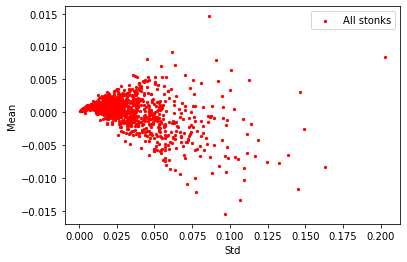

In [ ]:
stats.plot(x='Std', y='Mean', color="red", kind="scatter", marker=".", label='All stonks') # лайк за стонкс) 
plt.scatter(stats['Var']['IXIC'], stats['Mean']['IXIC'], marker=".", color="blue", label='Market index')
plt.legend()
plt.show()

## 3-4. Equally weighted portfolio, stock market index  

In [ ]:
#equally weighted portfolio return
sum_returns = 0
for ticker in tickers:
    sum_returns += stats['Mean'][ticker]
    
mean_balanced = sum_returns/len(tickers)
for i in range(len)

var_balanced = np.var(balanced_return)

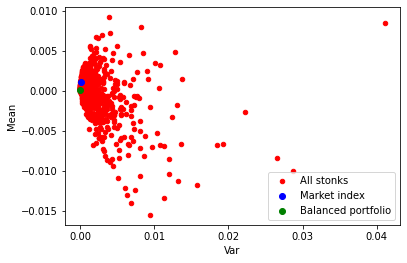

In [ ]:
stats.plot(x='Var', y='Mean', color="red", kind="scatter", label='All stonks')
plt.scatter(stats['Var']['IXIC'], stats['Mean']['IXIC'], color="blue", label='Market index')
plt.scatter(var_balanced, mean_balanced, color="green", label='Balanced portfolio')
plt.legend()
plt.show()

# 5. VaR

In [ ]:
#VaR_gam = mu + sigma*U_gamma where U_gamma is Z-score? wtf

gamma1 = 0.95
gamma2 = 0.90

gamma_quantile1 = scipy.stats.norm.ppf(gamma1) # percentage point function
gamma_quantile2 = scipy.stats.norm.ppf(gamma2)

z_score1, z_score2

VaR1 = stats['Std']*gamma_quantile1 + stats['Mean']
VaR2 = stats['Std']*gamma_quantile2 + stats['Mean']

(1.6448536269514722, 1.2815515655446004)

## 6. White noise

## 7. 

## 8. 